<a href="https://colab.research.google.com/github/ever-oli/MLby22/blob/main/AutoML2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

🚀 Initiating AutoML Pipeline...
--------------------------------------------------
📊 STEP 1: Exploratory Data Analysis

Dataset Shape: 891 rows, 11 columns

Missing Values per Column:
age            177
embarked         2
embark_town      2
dtype: int64


/tmp/ipython-input-743/1084433228.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=target_col, palette='viridis')


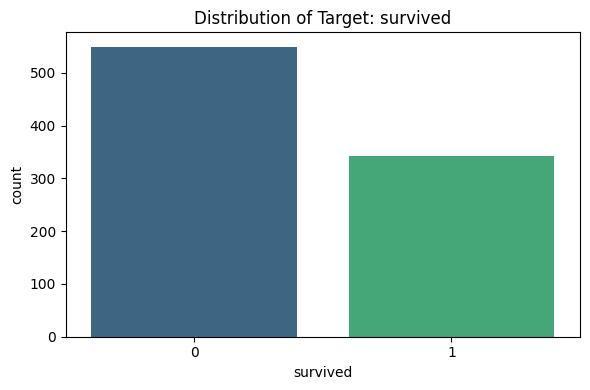


🛠️ STEP 2: Feature Identification
Numeric Features (5): ['pclass', 'age', 'sibsp', 'parch', 'fare']
Categorical Features (5): ['sex', 'embarked', 'class', 'embark_town', 'alone']

⚙️ STEP 3: Building Preprocessing Pipeline...

🧠 STEP 4: Training and Evaluating 5 Models (CV=5)...
  ✅ Logistic Regression  : Accuracy = 0.7958 (Std: ±0.0194)
  ✅ Random Forest        : Accuracy = 0.7969 (Std: ±0.0366)
  ✅ Gradient Boosting    : Accuracy = 0.8294 (Std: ±0.0236)
  ✅ SVC                  : Accuracy = 0.8283 (Std: ±0.0229)
  ✅ KNN                  : Accuracy = 0.7991 (Std: ±0.0324)
--------------------------------------------------
🏆 BEST MODEL: Gradient Boosting with 0.8294 Accuracy
Final model fitted on full dataset and ready for predictions.


In [2]:

# CUSTOM AUTOML PIPELINE FOR GOOGLE COLAB


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# Scikit-Learn tools
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

def custom_automl_classifier(df, target_col, cv_folds=5):
    """
    Takes a dataframe and target column, performs EDA, cleans data,
    engineers features, and evaluates 5 classification models.
    """
    print("🚀 Initiating AutoML Pipeline...")
    print("-" * 50)


    # 1. AUTOMATED EDA (Exploratory Data Analysis)

    print("📊 STEP 1: Exploratory Data Analysis\n")
    print(f"Dataset Shape: {df.shape[0]} rows, {df.shape[1]} columns")

    print("\nMissing Values per Column:")
    missing_data = df.isnull().sum()
    print(missing_data[missing_data > 0] if missing_data.sum() > 0 else "No missing values found!")

    # Plot Target Distribution
    plt.figure(figsize=(6, 4))
    sns.countplot(data=df, x=target_col, palette='viridis')
    plt.title(f'Distribution of Target: {target_col}')
    plt.tight_layout()
    plt.show()


    # 2. DATA SPLITTING & TYPING

    X = df.drop(columns=[target_col])
    y = df[target_col]

    numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_features = X.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

    print("\n🛠️ STEP 2: Feature Identification")
    print(f"Numeric Features ({len(numeric_features)}): {numeric_features}")
    print(f"Categorical Features ({len(categorical_features)}): {categorical_features}")


    # 3. DATA CLEANING & FEATURE ENGINEERING PIPELINE

    print("\n⚙️ STEP 3: Building Preprocessing Pipeline...")

    # Numeric: Impute with median, then scale
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    # Categorical: Impute with mode, then One-Hot Encode
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    # Combine into a single preprocessor
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])


    # 4. MODEL DEFINITION

    models = {
        'Logistic Regression': LogisticRegression(max_iter=2000),
        'Random Forest': RandomForestClassifier(random_state=42),
        'Gradient Boosting': GradientBoostingClassifier(random_state=42),
        'SVC': SVC(probability=True, random_state=42),
        'KNN': KNeighborsClassifier()
    }


    # 5. TRAINING & CROSS-VALIDATION

    print(f"\n🧠 STEP 4: Training and Evaluating {len(models)} Models (CV={cv_folds})...")
    results = {}

    for model_name, model in models.items():
        # Create a full pipeline containing preprocessing and the model
        clf_pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', model)
        ])

        # Calculate cross-validation accuracy
        scores = cross_val_score(clf_pipeline, X, y, cv=cv_folds, scoring='accuracy', n_jobs=-1)
        mean_accuracy = np.mean(scores)
        results[model_name] = mean_accuracy

        print(f"  ✅ {model_name.ljust(20)} : Accuracy = {mean_accuracy:.4f} (Std: ±{np.std(scores):.4f})")


    # 6. OUTPUT BEST MODEL

    best_model_name = max(results, key=results.get)
    best_accuracy = results[best_model_name]

    print("-" * 50)
    print(f"🏆 BEST MODEL: {best_model_name} with {best_accuracy:.4f} Accuracy")

    # Fit the best model on the entire dataset so it's ready to use
    final_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', models[best_model_name])
    ])
    final_pipeline.fit(X, y)
    print("Final model fitted on full dataset and ready for predictions.")

    return final_pipeline, results

# ==========================================
# EXAMPLE USAGE (Uncomment to test)
# ==========================================
import seaborn as sns
# Load a sample dataset (Titanic)
df = sns.load_dataset('titanic')
# Drop strictly identifying columns to keep it simple
df = df.drop(columns=['alive', 'who', 'adult_male', 'deck'])
#
best_model, eval_results = custom_automl_classifier(df, target_col='survived')